# 1 - Introduction

Name : Mukhlish Rasyidi

Batch : RMT-018

Dataset : tripadvisor_hotel_reviews.csv, merupakan dataset yang diperoleh dari kaggle.com pada page [Trip Advisor Hotel Reviews](https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews)

Objective: Dalam bidang hospitality, Service dan Experience adalah jasa yang dijual ke customer. Masing- masing manajemen hotel berusaha untuk memberikan yang terbaik agar mendapatkan review/ feedback yang positif dari customer. Pada kenyataannya tetap ada saja penyedia hotel yang berorientasi hanya pada keuntungan dan tidak peduli terhadap experience yang akan didapatkan customer. Sehingga ada customer yang memberikan review tidak baik atas experience yang dialami selama menginap.

Selain itu tahap kepuasan antar customer pun berbeda, dengan kondisi pelayanan yang sama bisa saja ada customer yang sudah merasa puas namun ada juga customer lain yang tidak merasa puas. Manajemen hotel yang baik akan menangkap Sentimen- sentimen dari review customer untuk perbaikan dan kemajuan hotel.

Dari permasalahan tersebut salah satu manajemen hotel meminta dibuatkan model untuk mempredict apakah review dari customernya termasuk sentimen positif, netral, atau negatif. Dengan mengetahui secara sistem tentunya akan membuat manajemen lebih mudah untuk memantau kepuasan customer tanpa harus terlebih dahulu menganalisis apakah reviewnya sentimen negatif, netral, ataupun positif secara manual.

Untuk membuat model sentimen review customer maka saya akan menggunakan libraries tensorflow dengan algoritma RNN dan menggunakan tipe Neuron LSTM. 

# 2 - Import Libraries

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
import seaborn as sns
import tensorflow as tf
from wordcloud import WordCloud
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, LSTM, GRU, Dropout,Bidirectional,Activation,BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import TextVectorization, Embedding
from keras.callbacks import EarlyStopping
from keras.models import load_model

# 3 - Data Loading

In [2]:
# Read dataset with csv format
df = pd.read_csv('https://raw.githubusercontent.com/mukhlishr/rasyidi/main/tripadvisor_hotel_reviews.csv')

In [3]:
# Duplicate dataset
df_copy = df.copy()

In [4]:
# Show the first 10 data
df.head(10)

Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5
5  love monaco staff husband stayed hotel crazy w...       5
6  cozy stay rainy city, husband spent 7 nights m...       5
7  excellent staff, housekeeping quality hotel ch...       4
8  hotel stayed hotel monaco cruise, rooms genero...       5
9  excellent stayed hotel monaco past w/e delight...       5

In [5]:
# Show the last 10 data
df.tail(10)

Review  Rating
20481  ok price look hotel ok little run average clea...       2
20482  great choice wife chose best western quite bit...       5
20483  good bed clean convenient just night happy sta...       4
20484  deceptive staff deceptive desk staff claiming ...       2
20485  not impressed unfriendly staff checked asked h...       2
20486  best kept secret 3rd time staying charm, not 5...       5
20487  great location price view hotel great quick pl...       4
20488  ok just looks nice modern outside, desk staff ...       2
20489  hotel theft ruined vacation hotel opened sept ...       1
20490  people talking, ca n't believe excellent ratin...       2

In [6]:
# Check overall dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


Berdasarkan pengecekan informasi umum dataset diketahui terdiri dari 2 columns dengan tipe data object (categoric) dan int64 (numeric ordinal). Jumlah keseluruhan data 20.491 dan tidak ada yang missing values. 

In [7]:
# Check describe dataset
df.describe()

Rating
count  20491.000000
mean       3.952223
std        1.233030
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000

Berdasarkan pengamatan terhadap columns rating yang bertipe numeric ordinal, terlihat tidak adanya outliers dimana skala nilai dari 1 - 5. Berdasarkan informasi dari datasetnya nilai 1 = sangat kurang, 2 = kurang, 3 = cukup, 4 = baik, dan 5 = sangat baik.

Terlihat untuk nilai mean dan mediannya dengan pembulatan memiliki kesamaan score yaitu 4.

# 4 - Exploratory Data (Original)

## 4.1 - Check Column rating

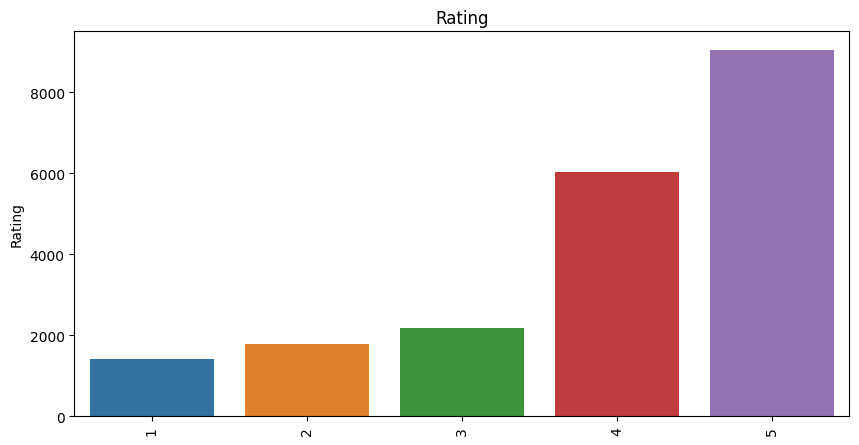

Jumlah : 
 1    1421
2    1793
3    2184
4    6039
5    9054
Name: Rating, dtype: int64
Percentage : 
 1     6.934752
2     8.750183
3    10.658338
4    29.471475
5    44.185252
Name: Rating, dtype: float64


In [8]:
# Check barplot ratings

fig, ax=plt.subplots(figsize=(10,5))
sns.barplot(x=df['Rating'].value_counts().index, y=df['Rating'].value_counts())
plt.xticks(rotation='vertical')
plt.title('Rating')
plt.show()
print('Jumlah : \n', df['Rating'].value_counts().sort_index())
print('Percentage : \n', (df['Rating'].value_counts().sort_index())/(df.shape[0]) * 100)

Terlihat dari rating, nilai rating terbanyak adalah rating 5 dengan keterangan sangat baik. Dan bila dibagi menjadi 3 sentimen, dimana sentimen negatif untuk nilai 1 dan 2, netral untuk nilai sama dengan 3, dan positif untuk nilai 4 dan 5. Maka mayoritas customer memberikan review atau feedback yang positif.

Akan dilakukan transformasi dari rating menjadi 3 kondisi sentimen sesuai dengan penjabaran diatas.

## 4.2 - Transform rating to sentimen and label

In [9]:
# Create function classification sentimen

def Sentimen(x):
  if  x<= 5 and x>3:
    return 'positive'
  if x== 3:
    return 'neutral'
  if x< 3 and x>=1:
    return 'negative'


In [10]:
# Create column 'sentimen'
df['sentimen'] = df['Rating'].apply(Sentimen)

In [11]:
# Crete column label

df['label'] = df['sentimen'].replace({'negative' : 0, 'neutral' : 1, 'positive' : 2})
df.head()

Review  Rating  sentimen  label
0  nice hotel expensive parking got good deal sta...       4  positive      2
1  ok nothing special charge diamond member hilto...       2  negative      0
2  nice rooms not 4* experience hotel monaco seat...       3   neutral      1
3  unique, great stay, wonderful time hotel monac...       5  positive      2
4  great stay great stay, went seahawk game aweso...       5  positive      2

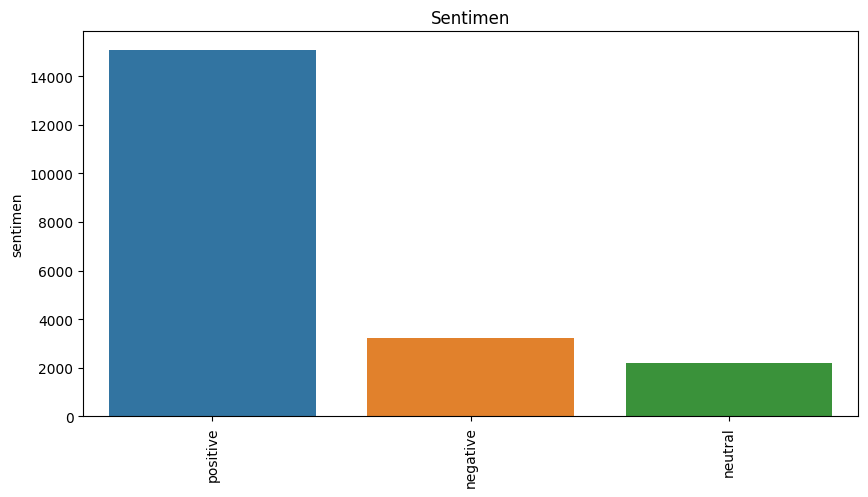

Jumlah : 
 negative     3214
neutral      2184
positive    15093
Name: sentimen, dtype: int64
Percentage : 
 negative    15.684935
neutral     10.658338
positive    73.656727
Name: sentimen, dtype: float64


In [12]:
# Check barplot sentimen

fig, ax=plt.subplots(figsize=(10,5))
sns.barplot(x=df['sentimen'].value_counts().index, y=df['sentimen'].value_counts())
plt.xticks(rotation='vertical')
plt.title('Sentimen')
plt.show()
print('Jumlah : \n', df['sentimen'].value_counts().sort_index())
print('Percentage : \n', (df['sentimen'].value_counts().sort_index())/(df.shape[0]) * 100)

Berdasarkan hasil transformasi rating menjadi sentimen, terlihat tidak balance data dimana sentimen positive mencapai 73.65%, sentimen netral 10.65%, dan sentimen negatif 15.68%.

## 4.3 - Check length of sentences

In [13]:
# Function to count sentence

def kalimat(data):
  sentences = data.split(".")
  for sentence in sentences:
    total_sentences = len(sentences)
    return total_sentences 

In [14]:
# Create column 'sentence'
df['sentences'] = df['Review'].apply(kalimat)
df.head()

Review  Rating  sentimen  label  \
0  nice hotel expensive parking got good deal sta...       4  positive      2   
1  ok nothing special charge diamond member hilto...       2  negative      0   
2  nice rooms not 4* experience hotel monaco seat...       3   neutral      1   
3  unique, great stay, wonderful time hotel monac...       5  positive      2   
4  great stay great stay, went seahawk game aweso...       5  positive      2   

   sentences  
0          1  
1          5  
2          8  
3          1  
4          2

In [15]:
# Check max and mean sentence all
print('Jumlah maximal kalimat pada dataset',df['sentences'].max())
print('Jumlah rata2 kalimat pada dataset',df['sentences'].mean())
print('Jumlah maximal kalimat pada setiap sentimen',df.groupby(['sentimen'])['sentences'].max().round(0))
print('Jumlah rata2 kalimat pada setiap sentimen',df.groupby(['sentimen'])['sentences'].mean().round(0))

Jumlah maximal kalimat pada dataset 102
Jumlah rata2 kalimat pada dataset 3.167536967449124
Jumlah maximal kalimat pada setiap sentimen sentimen
negative     37
neutral      83
positive    102
Name: sentences, dtype: int64
Jumlah rata2 kalimat pada setiap sentimen sentimen
negative    3.0
neutral     4.0
positive    3.0
Name: sentences, dtype: float64


Berdasarkan pengecekan jumlah kalimat dengan pembatas antar kalimat dengan tanda baca titik(.), diketahui jumlah maksimal kalimat ada 102 kalimat dalam satu review dan untuk rata2 kalimat 3 kalimat per review.

Untuk kalimat terbanyak ada pada review sentimen positive.

## 4.4 - Check length of words

In [16]:
# Function to count words
def kata(data):
  words = data.split()
  for word in words:
    total_words = len(words)
    return total_words


In [17]:
# Create column 'words'
df['words'] = df['Review'].apply(kata)
df.head()

Review  Rating  sentimen  label  \
0  nice hotel expensive parking got good deal sta...       4  positive      2   
1  ok nothing special charge diamond member hilto...       2  negative      0   
2  nice rooms not 4* experience hotel monaco seat...       3   neutral      1   
3  unique, great stay, wonderful time hotel monac...       5  positive      2   
4  great stay great stay, went seahawk game aweso...       5  positive      2   

   sentences  words  
0          1     87  
1          5    250  
2          8    217  
3          1     89  
4          2    191

In [18]:
# Check max and mean words
print('Jumlah maximal kata pada dataset',df['words'].max())
print('Jumlah rata2 kata pada dataset',df['words'].mean())
print('Jumlah maximal kata pada setiap sentimen',df.groupby(['sentimen'])['words'].max().round(0))
print('Jumlah rata2 kata pada setiap sentimen',df.groupby(['sentimen'])['words'].mean().round(0))

Jumlah maximal kata pada dataset 1931
Jumlah rata2 kata pada dataset 104.37582353228247
Jumlah maximal kata pada setiap sentimen sentimen
negative    1109
neutral     1931
positive    1755
Name: words, dtype: int64
Jumlah rata2 kata pada setiap sentimen sentimen
negative    120.0
neutral     115.0
positive     99.0
Name: words, dtype: float64


Untuk jumlah kata diketahui maksimal kata yaitu 1931 kata dalam satu kali review dengan rata2 kata adalah 104 kata. Jumlah kata terbanyak dalam satu kali review ada di sentimen neutral.

## 4.5 - Wordcloud

In [19]:
# Function to make wordcloud
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        max_words=200,
        max_font_size=45, 
        scale=1,
        random_state=1
).generate(" ".join(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

### Wordcloud all sentimen

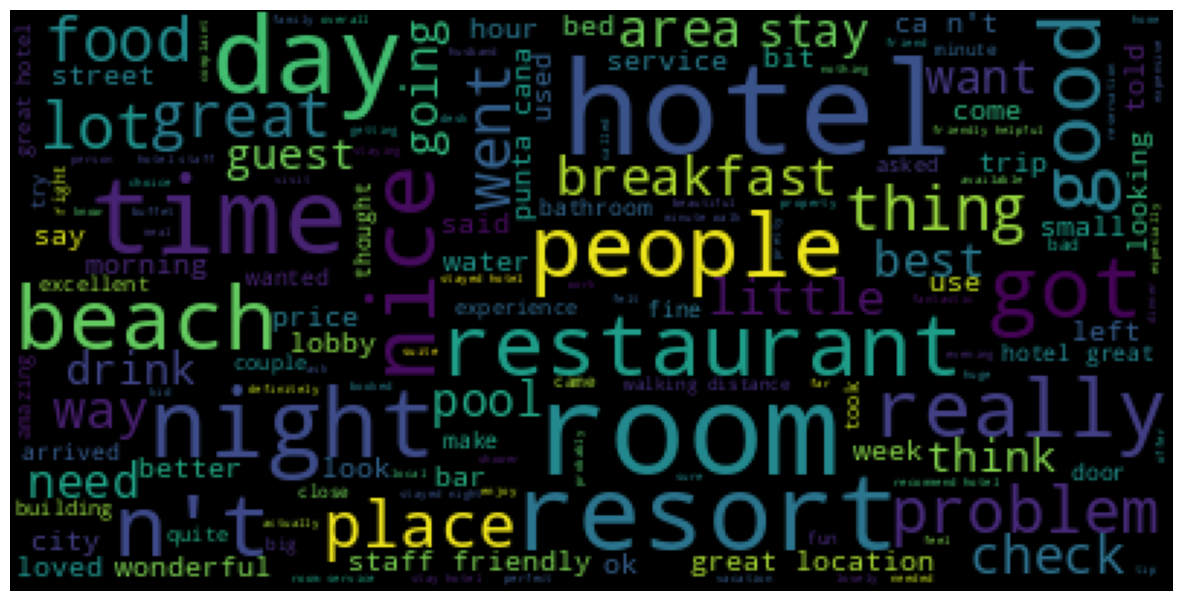

In [20]:
# Wordcloud all
show_wordcloud(df['Review'].values)

Berdasarkan kata yang paling banyak keluar adalah kata umum yaitu hotel, room, resort, day, time, resort, dan kata- kata yang menujukan tempat.

### Wordcloud sentimen positive

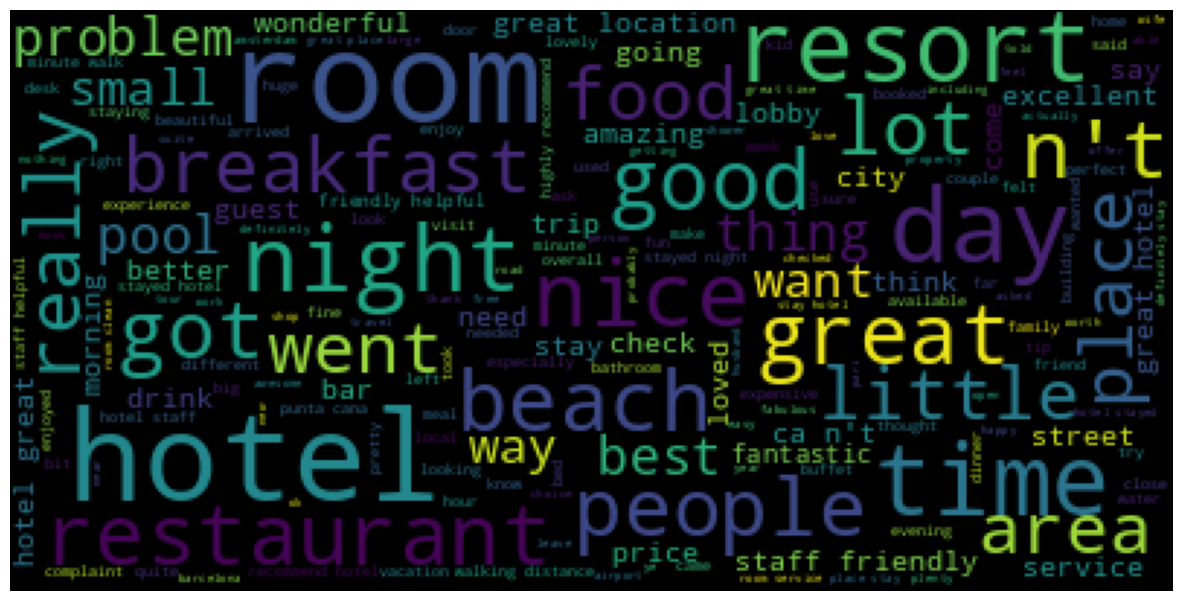

In [21]:
# Wordcloud Sentimen Positive
show_wordcloud(df[(df['Review']!=0) & (df['label']==2)]['Review'].values)

Dapat terlihat untuk wordcloud All dan Sentimen Positive mendekati sama. Dikarenakan hampir 75% datanya adalah sentimen positive, kemungkinan hampir semua kata ada pada sentimen positive. Hal ini akan membuat model kesulitin memprediksi sentimen lainnya.

### Wordcloud sentimen negative

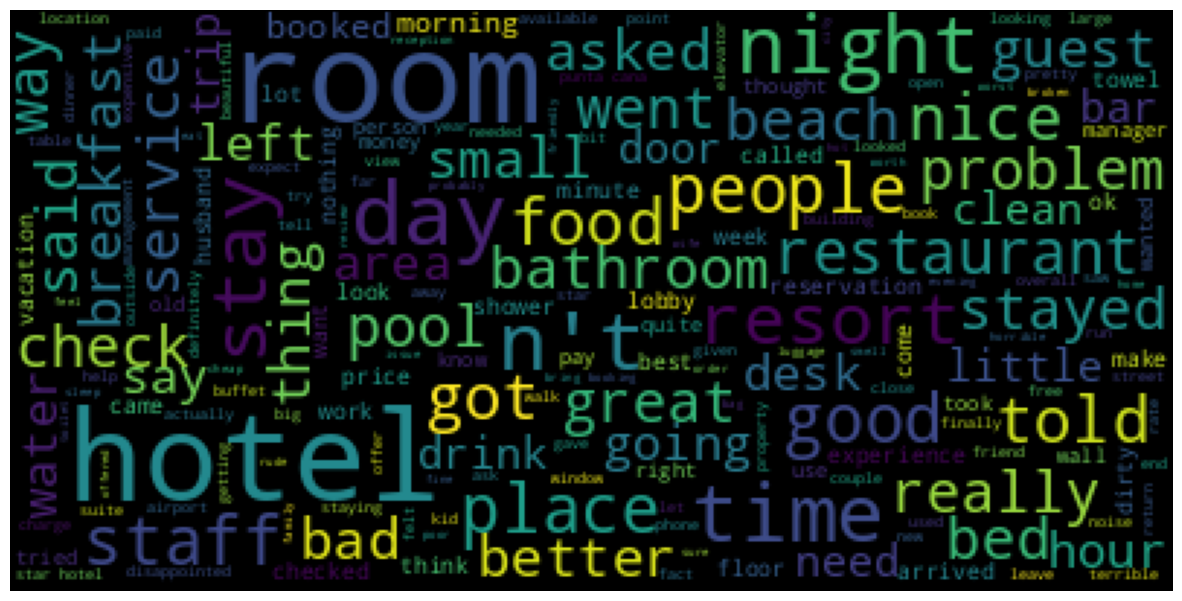

In [22]:
# Wordcloud sentimen negative
show_wordcloud(df[(df['Review']!=0) & (df['label']==0)]['Review'].values)

Terlihat untuk kata yang paling sering muncul di sentiment negatif, memiliki kesamaan dengan sentimen lain secara keseluruhan. Hal ini bisa menyebabkan model akan sulit untuk memprediksi sentimen negatif karena kata2nya masih terlalu umum yang dominantnya. perlu banyak dilakukan pembatasan kata/ preprocessing. Terlihat juga ada kata tidak penting seperti n't.

### Wordcloud sentimen netral

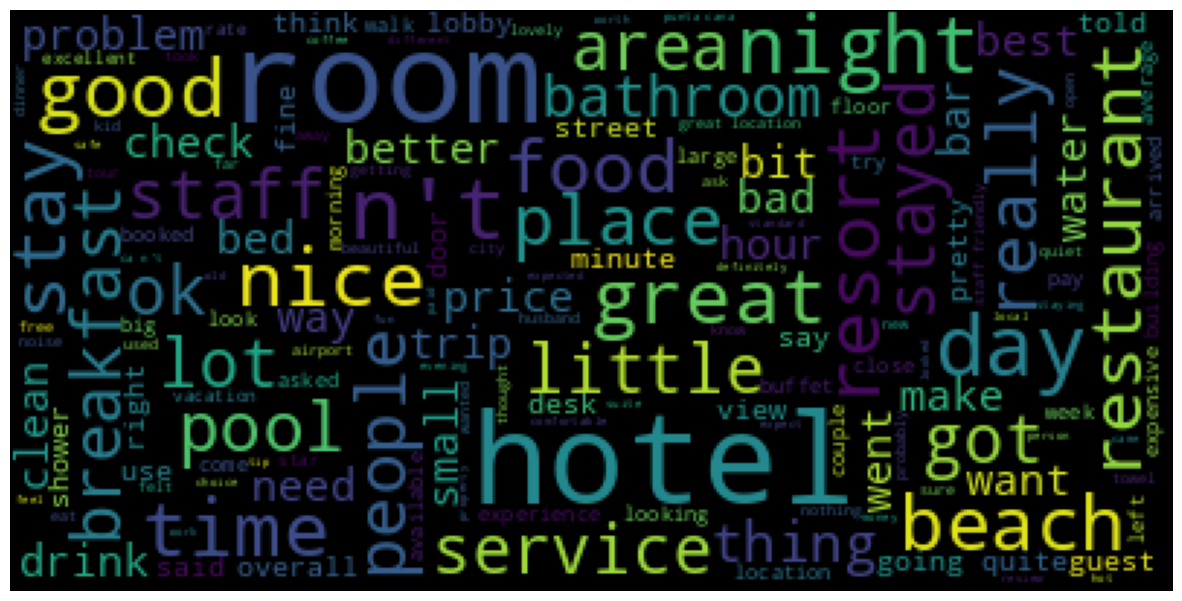

In [23]:
# Wordcloud Sentimen Netral
show_wordcloud(df[(df['Review']!=0) & (df['label']==1)]['Review'].values)

Dari Column sentimen netral juga memiliki kemiripan dengan sentimen negative dan positif. Model akan sangat sulit untuk bisa memprediksi sentimen netral.


Dari keseluruhan proses EDA dapat diketahui bahwa kondisi data tidak balance dengan proporsi data dengan sentimen positive mencapai 75% dan untuk dari hasil pengecekan wordcloud terlihat kesamaan kata yang paling dominan untuk disetiap sentimen. 

Hal ini mungkin terjadi karena transformasi rating dari 1- 5 menjadi 3 sentimen. Dengan menggunakan rating untuk memberi review, menurut saya bisa membuat bias untuk dilakukan analisis namun baik untuk sebagai promosi. Seseorang bisa sebenarnya tidak puas namun tetap memberikan rating 3, dan ada yang sebenarnya netral atau cukup memberikan nilai rating 4. Dan ada juga kebalikannya sebenarnya biasa saja tapi memberikan rating 2. 

Berbeda halnya ketika dari awal ditentukan penilaiannya hanya 3, baik, cukup, dan kurang. Dapat diperkirakan customer akan lebih aware dalam menentukan kategori reviewnya. 

Dengan kondisi dataset seperti ini, model akan sangat baik dalam ketepatan memprediksi sentiment positif, namun akan sangat kurang, atau bahkan tidak mampu untuk memprediksi sentimen negatif atau netral.


# 5 - Preprocessing

Pada bagian ini dilakukan preprocessing pada column reviews diantaranya menghilangkan angka, tanda baca, whitespace, stemming, lemma, vectorized, embeding, dan terakhir pipeline tensor flow.

## 5.1 - Stopword, remove non abjad, Lemmatize

In [26]:
# Define Stopwords

## Load Stopwords from NLTK
nltk.download('stopwords')
nltk.download('punkt')

stw_en = stopwords.words("english")

## Create A New Stopwords
new_stw = [ 'hotel', 'room','rooms','good','day','resort','night','restaurant','people','time', "n't", 'got' ,
 'staff',
 'stay',
 'location',
 'service',
 'stayed',
 'beach',
 'breakfast',
 'clean',
 'food',
 'place',
 'pool',
 'like',
 'really',
 'bed',
 'area',
  'bar',
 'small',
 'walk',
 'little',
 'bathroom',
 'trip',
 'floor',
 'minute',
 'water',
 'lot',
 'great',
 'nice',
 'went',
 'thing',
 'problem',
 'want',
 'drink',
 'way',
 'get',
 'go',
 'say'
 ]

## Merge Stopwords
stw_en = stw_en + new_stw
stw_en = list(set(stw_en))
print('Out Final Stopwords')
print(len(stw_en), stw_en)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Out Final Stopwords
227 ['an', 'more', 'because', 'but', 'so', "doesn't", 'over', 'have', 'its', 'the', 'area', 'any', 'yourselves', 'while', 'yours', 'above', "hasn't", 'ourselves', 'or', 'problem', 'minute', 'yourself', "wouldn't", 'were', "it's", 'way', 'y', 'of', "couldn't", 'wasn', 'all', 'their', 'weren', 'won', 'a', 'such', 'doesn', 've', 'day', 'night', 'stayed', 'like', 'out', 'hers', 'herself', 'her', 'hadn', 'than', 'through', 'into', 'how', 'haven', 'resort', 'he', 'she', 'when', 'itself', 'between', 'only', "needn't", 'can', 'drink', 'there', 'does', "you've", 'at', "you're", "isn't", 'to', 'with', 'bathroom', 'aren', "mightn't", 'people', "shan't", 'theirs', 'those', 'are', 'll', 'whom', 'off', 'under', 'is', 'now', 'shan', 'they', 'themselves', 'during', 'further', 'go', 'most', 'then', 'hotel', 'on', 'pool', 'bed', 'why', 'did', 'being', 'in', 'get', 'staff', "that'll", 'bar', 'room', "didn't", 'wouldn', 'which', 'if', 'am', 'stay', 'place', 'lot', 'should', "aren't", '

Pada bagian ini dilakukan penambahan kosa kata stopword dengan kata- kata dominan, mencoba mengurangi kata dominan  agar bisa mendapatkan kata yang spesifik untuk setiap sentimentnya.  

In [27]:
# Compare lemma and stemming
nltk.download('wordnet')
print('Original:')
print(df['Review'][0])
print()

sentence = []
for word in df['Review'][0].split():
    stemmer = SnowballStemmer('english')
    sentence.append(stemmer.stem(word))
print('Stemming:')
print(' '.join(sentence))
print()

sentence = []
for word in df['Review'][0].split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))
print('Lemmatization:')
print(' '.join(sentence))

Original:
nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  

Stemming:
nice hotel expens park got good deal stay hotel anniversary, arriv late even took advic previous review did valet parking, check quick easy, littl disappoint non-exist view room room clean nice size, bed comfort woke stiff neck high pillows, not soundproof like heard music room night morn loud bang door open close hear peopl talk hallway, mayb just noisi neighbors, aveda bath produc

[nltk_data] Downloading package wordnet to /root/nltk_data...


Lemmatization:
nice hotel expensive park get good deal stay hotel anniversary, arrive late even take advice previous review do valet parking, check quick easy, little disappoint non-existent view room room clean nice size, bed comfortable wake stiff neck high pillows, not soundproof like hear music room night morning loud bang doors open close hear people talk hallway, maybe just noisy neighbors, aveda bath products nice, do not goldfish stay nice touch take advantage stay longer, location great walk distance shopping, overall nice experience have pay 40 park night,


Berdasarkan result lemma dan stemming, dapat terlihat bahwa result lemma lebih baik. tidak banyak kata yang terpotong. maka untuk preprocessing yang akan digunakan adalah lemma.

In [28]:
# Membuat Function untuk preprocessing kata dalam dataframe


def text_proses(teks):
  # Mengubah Teks ke Lowercase
  teks = teks.lower()
  
  # Menghilangkan Mention
  teks = re.sub("@[A-Za-z0-9_]+", " ", teks)
  
  # Menghilangkan Hashtag
  teks = re.sub("#[A-Za-z0-9_]+", " ", teks)
  
  # Menghilangkan \n
  teks = re.sub(r"\\n", " ",teks)
  
  # Menghilangkan Whitespace
  teks = teks.strip()


  # Menghilangkan Link
  teks = re.sub(r"http\S+", " ", teks)
  teks = re.sub(r"www.\S+", " ", teks)

  # Menghilangkan yang Bukan Huruf seperti Emoji, Simbol Matematika (seperti μ), dst
  teks = re.sub("[^A-Za-z\s']", " ", teks)

  # Melakukan Tokenisasi
  tokens = word_tokenize(teks)

  # Menghilangkan Stopwords
  teks = ' '.join([word for word in tokens if word not in stw_en])

  return teks

Pada bagian ini dilakukan lower case,  menghilangkan tanda baca, emoticon, link, hashtag, angka, dan juga kata2 stopword, serta melakukan stemming. Tujuan dari bagian ini agar mengurangi jumlah vocab sehingga model bisa lebih simple dalam running dan ringkas waktu processnya. Karena ada kata yang bermakna sama namun beda penulisan membuat jumlahnya semakin banyak dan bisa membuat bias juga.

In [29]:
# Function lemmatizer
def lemmatize_text(text):
  sentence = []
  for word in text.split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))
  return ' '.join(sentence)


In [30]:
# Mengaplikasikan Semua Teknik Preprocessing ke dalam Semua Documents

df['text_processed'] = df['Review'].apply(text_proses)
df

Review  Rating  sentimen  \
0      nice hotel expensive parking got good deal sta...       4  positive   
1      ok nothing special charge diamond member hilto...       2  negative   
2      nice rooms not 4* experience hotel monaco seat...       3   neutral   
3      unique, great stay, wonderful time hotel monac...       5  positive   
4      great stay great stay, went seahawk game aweso...       5  positive   
...                                                  ...     ...       ...   
20486  best kept secret 3rd time staying charm, not 5...       5  positive   
20487  great location price view hotel great quick pl...       4  positive   
20488  ok just looks nice modern outside, desk staff ...       2  negative   
20489  hotel theft ruined vacation hotel opened sept ...       1  negative   
20490  people talking, ca n't believe excellent ratin...       2  negative   

       label  sentences  words  \
0          2          1     87   
1          0          5    250   
2          1          8    217   
3          2          1     89   
4          2          2    191   
...      ...        ...    ...   
20486      2          1    109   
20487      2          5     39   
20488      0          3     63   
20489      0         17    781   
20490      0          1     90   

                                          text_processed  
0      expensive parking deal anniversary arrived lat...  
1      ok nothing special charge diamond member hilto...  
2      experience monaco seattle level positives larg...  
3      unique wonderful monaco excellent short stroll...  
4      seahawk game awesome downfall view building co...  
...                                                  ...  
20486  best kept secret rd staying charm star ca beat...  
20487  price view quick sights directly street space ...  
20488  ok looks modern outside desk particularly frie...  
20489  theft ruined vacation opened sept guests week ...  
20490  talking ca believe excellent ratings yes patri...  

[20491 rows x 7 columns]

In [31]:
# lemmatize review
df['text_processed'] = df['text_processed'].apply(lemmatize_text)
df

Review  Rating  sentimen  \
0      nice hotel expensive parking got good deal sta...       4  positive   
1      ok nothing special charge diamond member hilto...       2  negative   
2      nice rooms not 4* experience hotel monaco seat...       3   neutral   
3      unique, great stay, wonderful time hotel monac...       5  positive   
4      great stay great stay, went seahawk game aweso...       5  positive   
...                                                  ...     ...       ...   
20486  best kept secret 3rd time staying charm, not 5...       5  positive   
20487  great location price view hotel great quick pl...       4  positive   
20488  ok just looks nice modern outside, desk staff ...       2  negative   
20489  hotel theft ruined vacation hotel opened sept ...       1  negative   
20490  people talking, ca n't believe excellent ratin...       2  negative   

       label  sentences  words  \
0          2          1     87   
1          0          5    250   
2          1          8    217   
3          2          1     89   
4          2          2    191   
...      ...        ...    ...   
20486      2          1    109   
20487      2          5     39   
20488      0          3     63   
20489      0         17    781   
20490      0          1     90   

                                          text_processed  
0      expensive park deal anniversary arrive late ev...  
1      ok nothing special charge diamond member hilto...  
2      experience monaco seattle level positives larg...  
3      unique wonderful monaco excellent short stroll...  
4      seahawk game awesome downfall view build compl...  
...                                                  ...  
20486  best keep secret rd stay charm star ca beat in...  
20487  price view quick sight directly street space n...  
20488  ok look modern outside desk particularly frien...  
20489  theft ruin vacation open sept guests week happ...  
20490  talk ca believe excellent rat yes patricia ext...  

[20491 rows x 7 columns]

## 5.2 - Wordcloud after preprocessing

### Wordcloud all sentimen





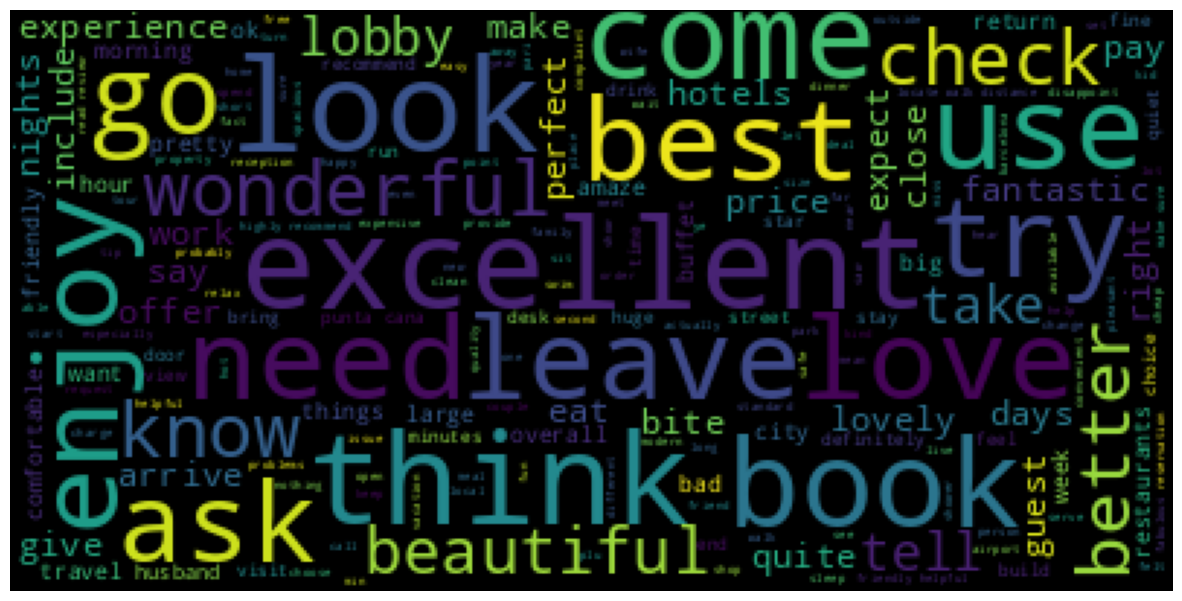

In [32]:
# Wordcloud all
show_wordcloud(df['text_processed'].values)

### Wordcloud sentimen negative

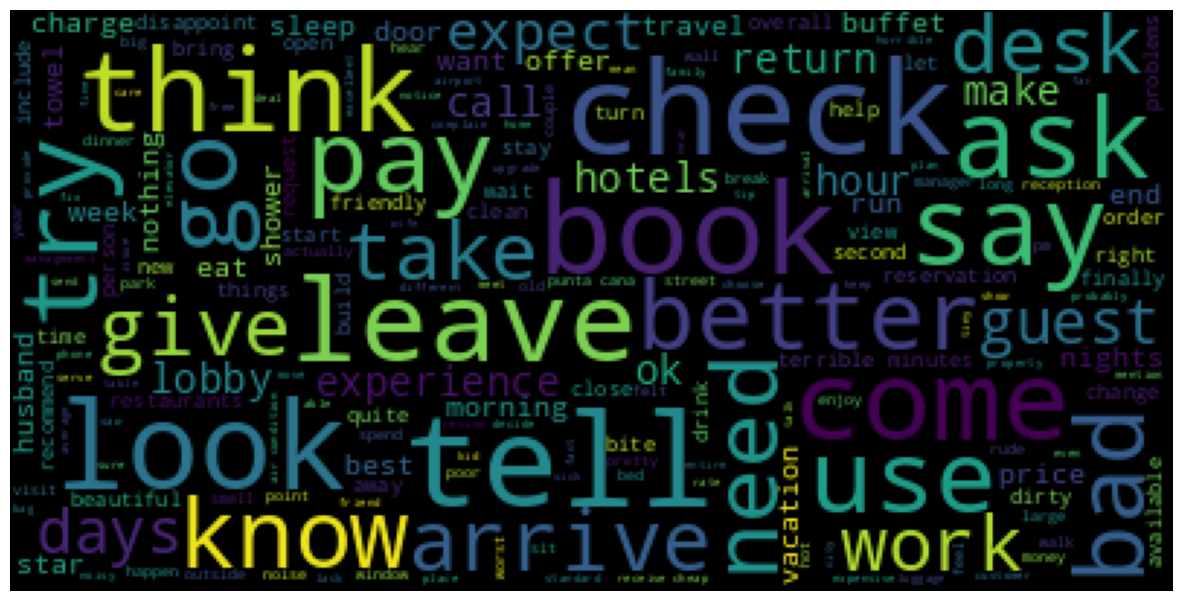

In [33]:
# Wordcloud sentimen negative
show_wordcloud(df[(df['text_processed']!=0) & (df['label']==0)]['text_processed'].values)

### Wordcloud sentimen netral

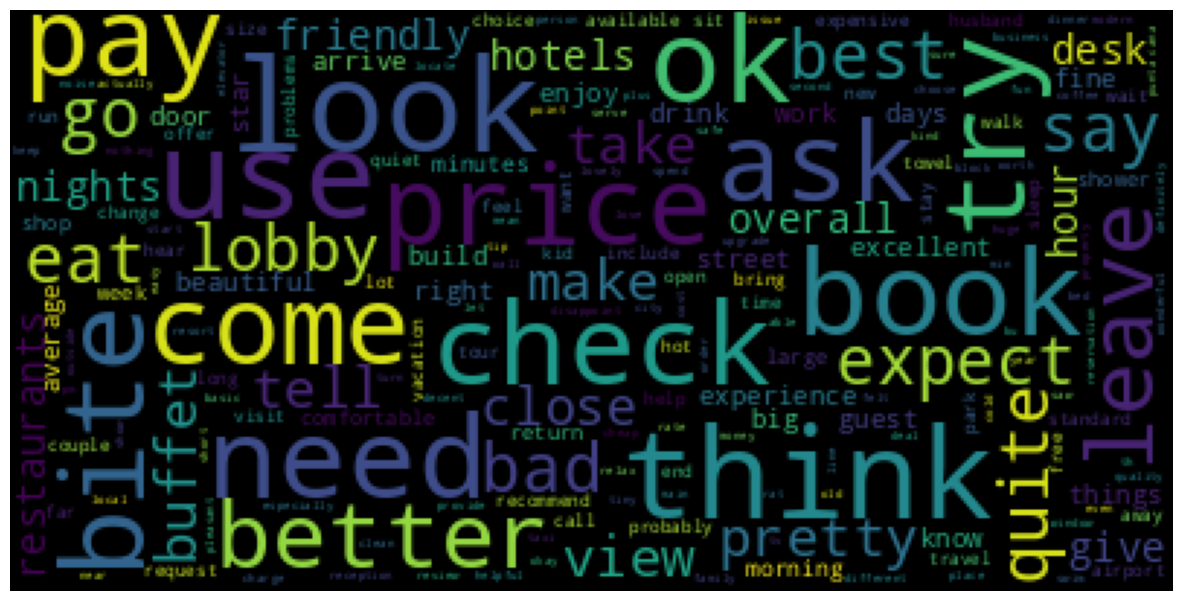

In [34]:
# Wordcloud Sentimen Netral
show_wordcloud(df[(df['text_processed']!=0) & (df['label']==1)]['text_processed'].values)

### Wordcloud sentimen positive

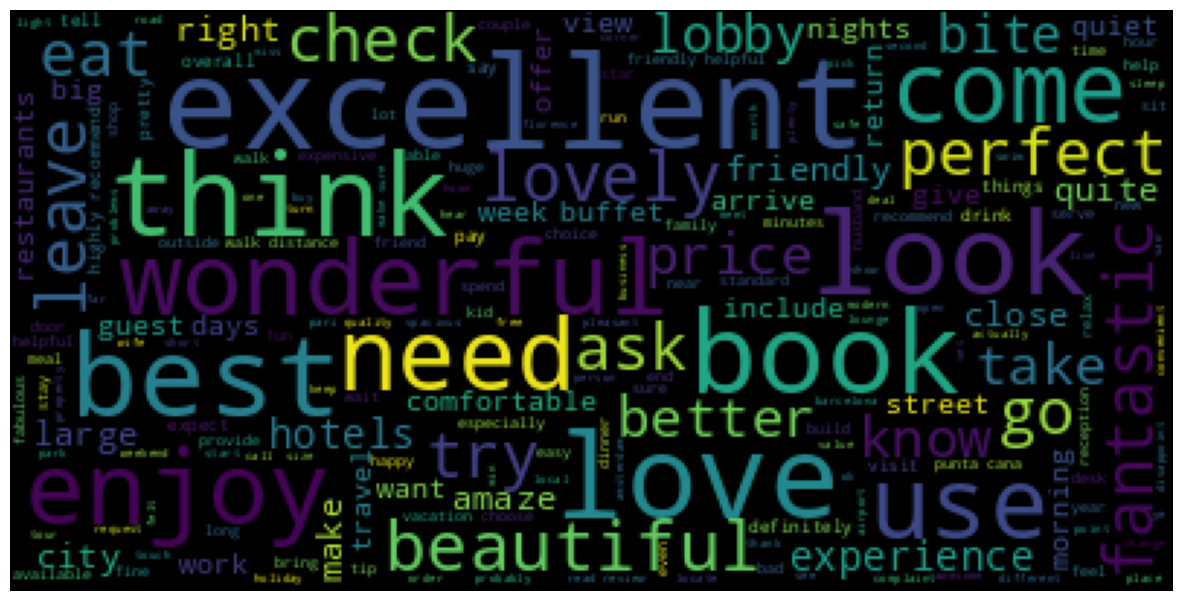

In [35]:
# Wordcloud Sentimen Positive
show_wordcloud(df[(df['text_processed']!=0) & (df['label']==2)]['text_processed'].values)

Terlihat setelah pengurangan kata menggunakan stopword, hasil dari wordcloud antar setiment mulai terlihat adanya perbedaan. Seperti kata excelent dan wonderful dominant di sentiment positif. Namun tetap masih ada beberapa kata yang masih muncul diketiga sentimen. 


## 5.3 - Split Train-set and Test-set

In [36]:
# Splitting X_train, X_test


X_train, X_test, y_train, y_test = train_test_split(df.text_processed, 
                                                    df.label, 
                                                    test_size=0.2, 
                                                    random_state=32, 
                                                    stratify=df.label)

print('Train Size : ', X_train.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (16392,)
Test Size  :  (4099,)


In [37]:
y_train.value_counts()

2    12074
0     2571
1     1747
Name: label, dtype: int64

Dari sini terlihat datanya sangat tidak balance antar sentimen. Ditambah dari hasil pengecekan wordcloud masih ada  yang dominan muncul di ketiga sentimen. 

Hal ini diprediksi akan membuat model kesulitan untuk memprediksi sentimen negatif dan netral

## 5.4 - Vectorize

Memecah kalimat menjadi kata dan mengurutkan sesuai dengan urutan dan menambahkan padding nilai 0 agar semua baris memiliki length yang sama. 

In [38]:
# Get Vocabularies

Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<16392x37788 sparse matrix of type '<class 'numpy.int64'>'
	with 1059223 stored elements in Compressed Sparse Row format>

In [39]:
# Mencari Jumlah Vocab dan Panjang Token dalam Satu DOcument

total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print("Jumlah vocab : ", total_vocab)
print("Panjang maksimum kalimat : ", max_sen_len, "kata")

Jumlah vocab :  37788
Panjang maksimum kalimat :  1584 kata


In [40]:
# Text Vectorization

text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,) 
                                       )

text_vectorization.adapt(X_train)

In [41]:
# Melihat Top 20 Token (Diurutkan Berdasarkan Frekuensi Kemunculan Terbesar)

text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'friendly',
 'book',
 'check',
 'excellent',
 'view',
 'look',
 'recommend',
 'make',
 'price',
 'helpful',
 'best',
 'use',
 'need',
 'restaurants',
 'come',
 'take',
 'think',
 'review']

## 5.5 - Embeding

Define untuk proses embeding dengan jumlah input sejumlah banyak kata dengan output yang diinginkan 100 output. 

In [42]:
# Embedding

embedding = Embedding(input_dim=total_vocab,
                      output_dim=100,
                      embeddings_initializer="HeUniform",
                      input_length=max_sen_len
                      )


## 5.6 - Change Target to One Hot Encoding

Merubah target label kedalam categorical, agar bisa melakukan pembobotan nilai untuk setiap sentimen. dan nilai terbesar akan masuk ke dalam sentimen tersebut.

In [43]:
# Mengubah Target ke dalam One Hot Encoding

from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
y_train_cat

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)


## 5.7 - Pipeline tensorflow

Pada bagian ini dilakukan proses extraksi dan persiapan load data menggunakan tensorflow pipeline. Pengelompokan train dan test dengan pembagian batch per 300 data, kemudian dilakukan shufle sejumlah baris, dan mengaktifkan prefetch menjadi autotune agar bisa lebih cepat dalam proses antar gpu dan cpu.

In [44]:
# Pipeline Tensorflow
train_pipe = tf.data.Dataset.from_tensor_slices((X_train, y_train_cat)).batch(300).shuffle(len(X_train)).prefetch(tf.data.AUTOTUNE)
test_pipe = tf.data.Dataset.from_tensor_slices((X_test,y_test_cat)).batch(300)



# 6 - RNN LSTM

## 6.1 - Model Definition

Model yang pertama kali digunakan adalah LSTM yang merupakan upgrade dari kelemahan RNN yang hanya bisa mengingat maksimal 10 kejadian dengan sequential.

Tahapan paling awal yaitu memasukan proses text_vectorization untuk sebagai input dan mengganti kata dengan urutan nilai dengan jumlah sesuai dengan maksimal panjang kata.  Kemudian dilakukan embeding dan dilakukan learning dengan layer lstm menggunkan 16 neuron di layer lstm 1, setelahnya dilakukan dropout baru kemudian dilakukan leraning lagi menggunakan layer lstm dengan 3 neuron. sejumlah output. activation yang digunakan harus softmax karena untuk ouput categorical dan optimizernya Adam.

In [102]:
# Model Definition 

tf.keras.backend.clear_session()
model_lstm = Sequential()
model_lstm.add(text_vectorization)
model_lstm.add(embedding)
model_lstm.add(LSTM(16, return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(3,activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')
model_lstm.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1584)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1584, 100)         3778800   
                                                                 
 lstm (LSTM)                 (None, 1584, 16)          7488      
                                                                 
 dropout (Dropout)           (None, 1584, 16)          0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                6272      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

## 6.2 - Model Training

In [103]:
# Model Training dengan Menggunakan LSTM
%%time
model_lstm_his = model_lstm.fit(train_pipe,
                         epochs=30,
                         validation_data=test_pipe)

Epoch 1/30
55/55 [==============================] - 10s 111ms/step - loss: 0.8604 - accuracy: 0.7324 - val_loss: 0.7548 - val_accuracy: 0.7365
Epoch 2/30
55/55 [==============================] - 5s 95ms/step - loss: 0.7744 - accuracy: 0.7366 - val_loss: 0.7571 - val_accuracy: 0.7365
Epoch 3/30
55/55 [==============================] - 5s 96ms/step - loss: 0.7719 - accuracy: 0.7366 - val_loss: 0.7554 - val_accuracy: 0.7365
Epoch 4/30
55/55 [==============================] - 5s 95ms/step - loss: 0.7677 - accuracy: 0.7366 - val_loss: 0.7556 - val_accuracy: 0.7365
Epoch 5/30
55/55 [==============================] - 5s 95ms/step - loss: 0.7648 - accuracy: 0.7366 - val_loss: 0.7549 - val_accuracy: 0.7365
Epoch 6/30
55/55 [==============================] - 5s 95ms/step - loss: 0.7665 - accuracy: 0.7366 - val_loss: 0.7568 - val_accuracy: 0.7365
Epoch 7/30
55/55 [==============================] - 5s 95ms/step - loss: 0.7650 - accuracy: 0.7366 - val_loss: 0.7545 - val_accuracy: 0.7365
Epoch 8/30


## 6.3 - Model Evaluation

In [104]:
# Create DataFrame

history_lstm = pd.DataFrame(model_lstm_his.history)
history_lstm

loss  accuracy  val_loss  val_accuracy
0   0.860441  0.732369  0.754776      0.736521
1   0.774380  0.736579  0.757120      0.736521
2   0.771891  0.736579  0.755357      0.736521
3   0.767719  0.736579  0.755645      0.736521
4   0.764817  0.736579  0.754868      0.736521
5   0.766488  0.736579  0.756837      0.736521
6   0.764957  0.736579  0.754548      0.736521
7   0.764997  0.736579  0.754552      0.736521
8   0.764015  0.736579  0.754830      0.736521
9   0.766171  0.736579  0.755116      0.736521
10  0.762990  0.736579  0.755244      0.736521
11  0.763454  0.736579  0.754494      0.736521
12  0.762392  0.736579  0.754553      0.736521
13  0.763500  0.736579  0.754973      0.736521
14  0.762727  0.736579  0.754492      0.736521
15  0.761923  0.736579  0.754478      0.736521
16  0.761567  0.736579  0.754503      0.736521
17  0.761538  0.736579  0.754524      0.736521
18  0.759915  0.736579  0.754545      0.736521
19  0.759545  0.736579  0.754570      0.736521
20  0.759937  0.736579  0.754883      0.736521
21  0.761295  0.736579  0.754694      0.736521
22  0.760903  0.736579  0.755381      0.736521
23  0.760581  0.736579  0.755335      0.736521
24  0.759757  0.736579  0.754576      0.736521
25  0.759062  0.736579  0.754622      0.736521
26  0.760110  0.736579  0.754482      0.736521
27  0.758507  0.736579  0.754592      0.736521
28  0.759414  0.736579  0.754639      0.736521
29  0.759603  0.736579  0.754741      0.736521

<Axes: >

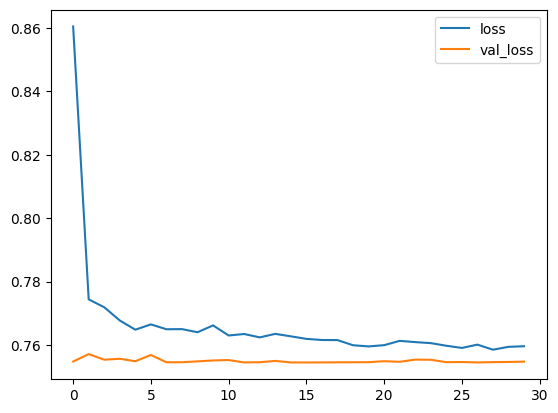

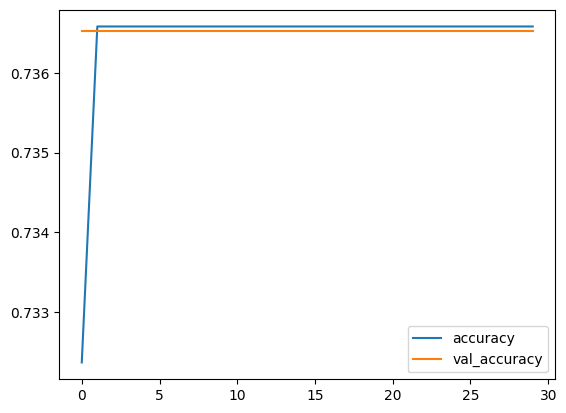

In [105]:
# Plot Training Results

history_lstm[['loss', 'val_loss']].plot()
history_lstm[['accuracy', 'val_accuracy']].plot()

Terlihat dari grafik dengan epoch sebanyak 30 kali, model ini terlihatnya goodfit karena gapnya sangat kecil antara train dan testnya, tapi terlihat untuk test/val nilainya statis dari awal sampai akhir. Hal ini menandakan adanya sesuatu yang aneh atau tidak normal.

In [106]:
# Check Performance Model against Test-Set
y_pred = model_lstm.predict(X_test)
y_pred_conv= np.where(y_pred >= 0.5, 1, 0)
print(classification_report(y_test_cat, y_pred_conv,zero_division=0))


129/129 [==============================] - 5s 32ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       643
           1       0.00      0.00      0.00       437
           2       0.74      1.00      0.85      3019

   micro avg       0.74      0.74      0.74      4099
   macro avg       0.25      0.33      0.28      4099
weighted avg       0.54      0.74      0.62      4099
 samples avg       0.74      0.74      0.74      4099



In [107]:
#y_test1 = y_test.reset_index(drop=True)
y_pred_df = pd.DataFrame(y_pred_conv, columns=['0', '1', '2'])
y_pred_final=y_pred_df.idxmax(1).astype(int)

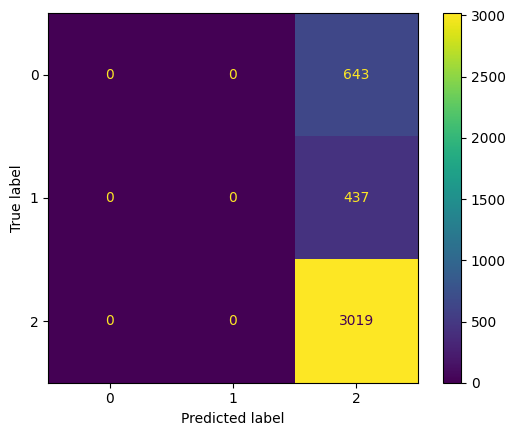

In [108]:
ConfusionMatrixDisplay.from_predictions(y_test1, y_pred_final)

Dari hasil clasification report dan confussion matrix terlihat sangat jelas model LSTM baseline ini memiliki kelemahan tidak bisa memprediksi untuk sentimen netral dan negatif. Semuanya terprediksi sentimen positif. Padahal ada 26% yang bukan sentimen positif, sehingga nilai precissionnya 74%. dan Recallnya 100 karena tidak ada yang terprediksi. 

Hal ini sesuai dengan perkiraaan dari proses EDA karena data yang tidak balance dan banyak kata terwakili pada sentimen positif. Dalam segi bisnis, model ini tidak baik karena bisa membuat manajemen beranggapan semua reviewnya sentimen positif, padahal sebenarnya 26% bersentimen negative dan netral. 

# 7 - RNN GRU

## 7.1 - Model Definition

Untuk model ini menggunkan layers dengan jenis Gated Recurrent Unit. dengan tahapan awal sama dengan yang LSTM, yang membedakan pada baseline ini jumlah neuron layar ke 2, 2 kali lipat dibanding dengan layers yang pertama.  Untuk activation tetap menggunakan softmax karena sesuai tujuan categorical. 


In [ ]:
# Model Definition
tf.keras.backend.clear_session()
model = Sequential()
model.add(text_vectorization)
model.add(embedding)
model.add(GRU(32, return_sequences=True))
model.add(GRU(64))
model.add(Dense(3,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')

## 7.2 - Model Training

In [109]:
# Model Training dengan Menggunakan GRU

model_gru= model.fit(train_pipe,
                         epochs=30,
                         validation_data=test_pipe)

Epoch 1/30
55/55 [==============================] - 10s 127ms/step - loss: 0.8192 - accuracy: 0.7246 - val_loss: 0.7554 - val_accuracy: 0.7365
Epoch 2/30
55/55 [==============================] - 6s 115ms/step - loss: 0.7550 - accuracy: 0.7366 - val_loss: 0.7568 - val_accuracy: 0.7365
Epoch 3/30
55/55 [==============================] - 6s 115ms/step - loss: 0.7555 - accuracy: 0.7366 - val_loss: 0.7549 - val_accuracy: 0.7365
Epoch 4/30
55/55 [==============================] - 6s 115ms/step - loss: 0.7547 - accuracy: 0.7366 - val_loss: 0.7550 - val_accuracy: 0.7365
Epoch 5/30
55/55 [==============================] - 6s 115ms/step - loss: 0.7548 - accuracy: 0.7366 - val_loss: 0.7545 - val_accuracy: 0.7365
Epoch 6/30
55/55 [==============================] - 6s 115ms/step - loss: 0.7561 - accuracy: 0.7366 - val_loss: 0.7548 - val_accuracy: 0.7365
Epoch 7/30
55/55 [==============================] - 6s 115ms/step - loss: 0.7547 - accuracy: 0.7366 - val_loss: 0.7551 - val_accuracy: 0.7365
Epoch

## 7.3 - Model Evaluation

In [110]:
# Create DataFrame

history_gru = pd.DataFrame(model_gru.history)
history_gru

loss  accuracy  val_loss  val_accuracy
0   0.819189  0.724622  0.755381      0.736521
1   0.754950  0.736579  0.756787      0.736521
2   0.755458  0.736579  0.754853      0.736521
3   0.754707  0.736579  0.754950      0.736521
4   0.754806  0.736579  0.754484      0.736521
5   0.756111  0.736579  0.754752      0.736521
6   0.754722  0.736579  0.755095      0.736521
7   0.755250  0.736579  0.754515      0.736521
8   0.754999  0.736579  0.755048      0.736521
9   0.756029  0.736579  0.755887      0.736521
10  0.754665  0.736579  0.754831      0.736521
11  0.754754  0.736579  0.754996      0.736521
12  0.754858  0.736579  0.754870      0.736521
13  0.755221  0.736579  0.754649      0.736521
14  0.756157  0.736579  0.754673      0.736521
15  0.754873  0.736579  0.754927      0.736521
16  0.755217  0.736579  0.754814      0.736521
17  0.755259  0.736579  0.756874      0.736521
18  0.755148  0.736579  0.754719      0.736521
19  0.755233  0.736579  0.754993      0.736521
20  0.754994  0.736579  0.754831      0.736521
21  0.755007  0.736579  0.754498      0.736521
22  0.754965  0.736579  0.755684      0.736521
23  0.755216  0.736579  0.756230      0.736521
24  0.755302  0.736579  0.755388      0.736521
25  0.755216  0.736579  0.754581      0.736521
26  0.755019  0.736579  0.754503      0.736521
27  0.755013  0.736579  0.754721      0.736521
28  0.754689  0.736579  0.756174      0.736521
29  0.754998  0.736579  0.754939      0.736521

<Axes: >

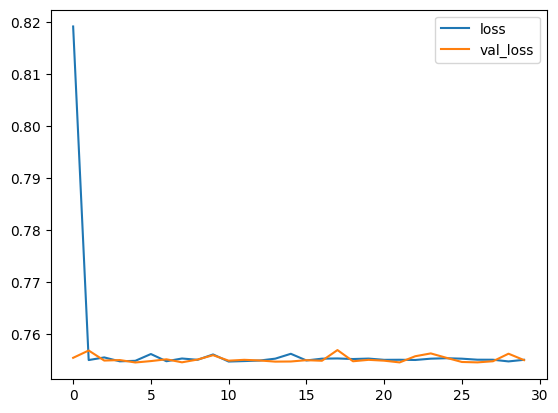

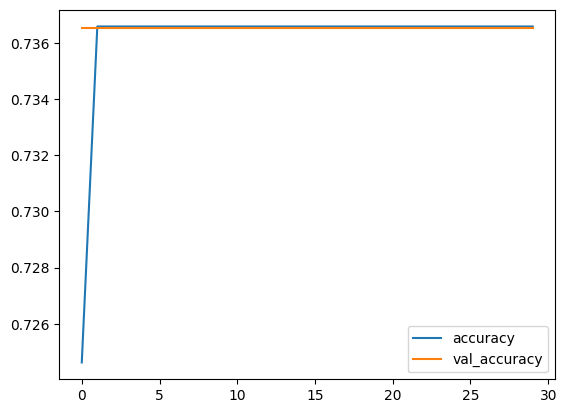

In [111]:
# Plot Training Results

history_gru[['loss', 'val_loss']].plot()
history_gru[['accuracy', 'val_accuracy']].plot()

Dari hasil train test dengan metric accuracy dan lost, terlihat untuk model ini terlihat lebih baik dengan gap yang sangat kecil bahkan hampir sama nilainya antara train dan test. Tapi tetap memiliki pattern yang sama karena nilainya testnya statis dari awal.

In [112]:
# Check Performance Model against Test-Set
y_pred = model.predict(X_test)
y_pred_conv= np.where(y_pred >= 0.7, 1, 0)
print(classification_report(y_test_cat, y_pred_conv,zero_division=0))


129/129 [==============================] - 5s 34ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       643
           1       0.00      0.00      0.00       437
           2       0.74      1.00      0.85      3019

   micro avg       0.74      0.74      0.74      4099
   macro avg       0.25      0.33      0.28      4099
weighted avg       0.54      0.74      0.62      4099
 samples avg       0.74      0.74      0.74      4099



In [113]:
y_test1 = y_test.reset_index(drop=True)
y_pred_df = pd.DataFrame(y_pred_conv, columns=['0', '1', '2'])
y_pred_final=y_pred_df.idxmax(1).astype(int)

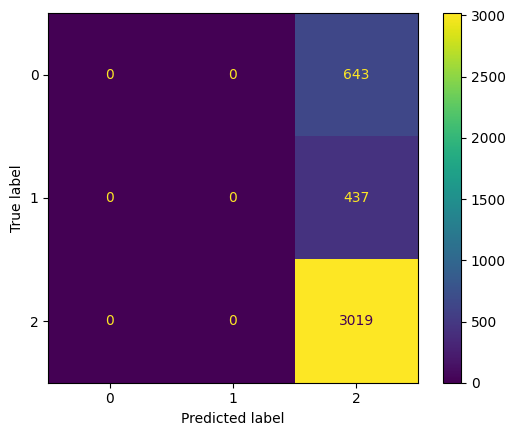

In [114]:
ConfusionMatrixDisplay.from_predictions(y_test1, y_pred_final)

Berdasarkan pengamatan dari nilai classification report dan confusion matrix, model ini juga memiliki kelemahan hanya bisa memprediksi bahwa review dari customer sentimentnya positif semua. dengan kesalahan 26% dari yang terprediksi positif ternyata adalah sentimen negatif dan netral.

Dari 2 hasil model maka sangat jelas perlu dilakukan improve karena model bila dikaitkan dengan business hanya memiliki 1 kelebihan, yaitu ABS ( Asal Bos Senang) karena terlihatnya semua reviewn tamunya puas dan manajemen sudah bagus. Namun pada dasarnya belum tentu.  

# 8-  RNN LSTM Improvement

## 8.1 - Model Definition

Hal yang diperhatikan adalah bagaimana model ini bisa membaca atau memprediksi sentimen selain dari sentimen positif. Meskipun sebenarnya mungkin hanya bisa sedikit menaikan datanya bila tidak melakukan over sampling atau balancing datanya agar tidak terlalu jauh gap datanya.

Perkiraan pertama karena model diawal tidak mendefine initializer / bobot sehingga nilainya akan terbaca penuh untuk yang mayoritas. Kemudian bisa jadi jumlah neuron yang digunakan terlalu sedikit dibandingkan dengan jumlah total parameter yang mencapai 4 juta lebih param.

Selain dari jumlah neuron, ada kemungkinan karena tidak dilakukan normalization setiap batchnya sehingga tidak bisa membaca dengan baik. 

Kemudian ditambahkan statement bidirectional agar proses informasi 2 arah dari future dan past lsg diproses secara bersamaan.

Dan setelahnya menggunakan early stop dengan accuracy untuk mendapatkan accuracy val / test yang terbaik. dari kondisi2 diatas maka untuk neuronnya dinaikan saat di layer 1 sebanyak 128 neuron dan di layer ke dinaikan namun tidak terlalu jauh kenaikannya menjadi 160 neuron.

Untuk initializer menggunkan HeUniform yang sebelumnya default glorot normal.

In [82]:
# Model Definition dengan Menggunakan LSTM

tf.keras.backend.clear_session()
model_lstm1 = Sequential()
model_lstm1.add(text_vectorization)
model_lstm1.add(embedding)
model_lstm1.add(Bidirectional(LSTM(128, return_sequences=True, kernel_initializer='HeUniform', recurrent_initializer='HeUniform')))
model_lstm1.add(Dropout(0.5))
model_lstm1.add(BatchNormalization())
model_lstm1.add(Bidirectional(LSTM(160)))
model_lstm1.add(Dropout(0.5))
model_lstm1.add(BatchNormalization())
model_lstm1.add(Dense(3,activation='softmax'))
model_lstm1.compile(loss='categorical_crossentropy',optimizer=tf.optimizers.Adam(learning_rate=0.0001),metrics='accuracy')
model_lstm1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1584)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1584, 100)         3778800   
                                                                 
 bidirectional (Bidirectiona  (None, 1584, 256)        234496    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 1584, 256)         0         
                                                                 
 batch_normalization (BatchN  (None, 1584, 256)        1024      
 ormalization)                                                   
                                                        

In [81]:
#callback early stoping
es = EarlyStopping(monitor='val_accuracy',patience=5, mode='auto', verbose=1)

## 8.2 - Model Training

In [83]:
# Model Training
%%time
model_lstm_his = model_lstm1.fit(train_pipe,
                         epochs=30,
                         validation_data=test_pipe, callbacks=[es])

Epoch 1/30
55/55 [==============================] - 33s 461ms/step - loss: 1.4743 - accuracy: 0.3579 - val_loss: 1.0550 - val_accuracy: 0.5233
Epoch 2/30
55/55 [==============================] - 17s 301ms/step - loss: 1.3618 - accuracy: 0.4015 - val_loss: 0.9737 - val_accuracy: 0.5575
Epoch 3/30
55/55 [==============================] - 17s 300ms/step - loss: 1.2307 - accuracy: 0.4520 - val_loss: 0.9773 - val_accuracy: 0.5514
Epoch 4/30
55/55 [==============================] - 17s 301ms/step - loss: 1.0568 - accuracy: 0.5347 - val_loss: 1.2329 - val_accuracy: 0.4533
Epoch 5/30
55/55 [==============================] - 17s 302ms/step - loss: 0.8298 - accuracy: 0.6762 - val_loss: 1.1684 - val_accuracy: 0.7504
Epoch 6/30
55/55 [==============================] - 17s 303ms/step - loss: 0.6585 - accuracy: 0.7653 - val_loss: 1.3768 - val_accuracy: 0.7529
Epoch 7/30
55/55 [==============================] - 17s 302ms/step - loss: 0.5537 - accuracy: 0.8088 - val_loss: 1.3267 - val_accuracy: 0.7838

## 8.3 - Model Evaluation

In [84]:
# Create DataFrame

history_lstm_imp = pd.DataFrame(model_lstm_his.history)
history_lstm_imp

loss  accuracy  val_loss  val_accuracy
0   1.474280  0.357857  1.055040      0.523298
1   1.361812  0.401476  0.973740      0.557453
2   1.230693  0.451989  0.977294      0.551354
3   1.056834  0.534712  1.232945      0.453281
4   0.829817  0.676184  1.168366      0.750427
5   0.658480  0.765251  1.376771      0.752867
6   0.553708  0.808809  1.326693      0.783850
7   0.483150  0.831381  1.305023      0.784094
8   0.434441  0.846999  1.405883      0.781654
9   0.405536  0.856088  1.636577      0.779946
10  0.367820  0.866215  1.609896      0.786045
11  0.341837  0.876342  1.627874      0.789705
12  0.315886  0.888970  1.456452      0.784582
13  0.287136  0.896718  1.597271      0.781898
14  0.268773  0.903673  1.622096      0.783362
15  0.249995  0.910261  1.699463      0.779214
16  0.231571  0.917887  1.580379      0.785801

<Axes: >

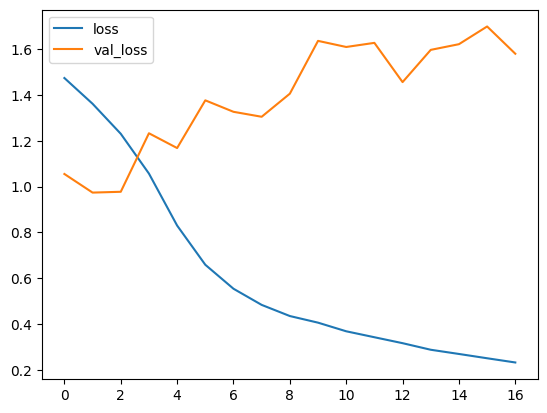

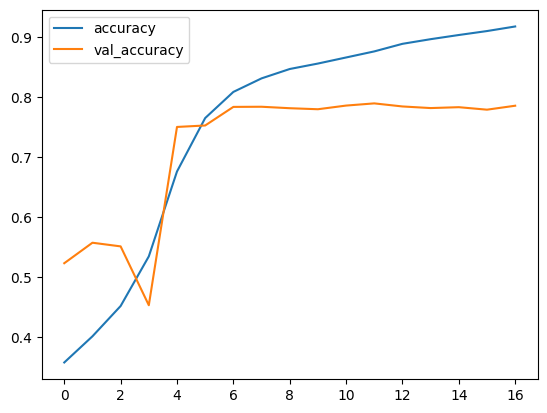

In [85]:
# Plot Training Results

history_lstm_imp[['loss', 'val_loss']].plot()
history_lstm_imp[['accuracy', 'val_accuracy']].plot()

Dari hasil training dengan 30 kali pengulangan terlihat bila dari loss termasuk over fitting dimana nilai val_loss semakin naik dan dipengulangan ke 16 mencapai 1.6 sementara loss untuk train sudah hampir 0, yaitu 0.2. 

Namun pada sebenarnya bisa jadi untuk val_lostnya akan menurun karena dengan early stopping sudah di stop saat pengulangan ke 16 karena sudah mendapatkan tess acuracy terbaik dan 5 diatasnya sudah tidak ada yang lebih baik lagi.

In [86]:
# Check Performance Model against Test-Set
y_pred = model_lstm1.predict(X_test)
y_pred_conv= np.where(y_pred >= 0.5, 1, 0)
print(classification_report(y_test_cat, y_pred_conv,zero_division=0))


129/129 [==============================] - 11s 74ms/step
              precision    recall  f1-score   support

           0       0.69      0.45      0.54       643
           1       0.24      0.05      0.08       437
           2       0.81      0.96      0.88      3019

   micro avg       0.79      0.78      0.79      4099
   macro avg       0.58      0.49      0.50      4099
weighted avg       0.73      0.78      0.74      4099
 samples avg       0.78      0.78      0.78      4099



In [87]:
y_test1 = y_test.reset_index(drop=True)
y_pred_df = pd.DataFrame(y_pred_conv, columns=['0', '1', '2'])
y_pred_final=y_pred_df.idxmax(1).astype(int)

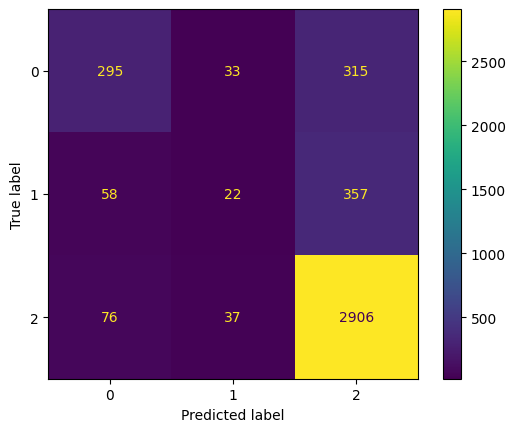

In [88]:
ConfusionMatrixDisplay.from_predictions(y_test1, y_pred_final)

Bila dilihat dari classification report dan confussion matrix dapat terlihat bahwa model improve ini sudah ada kemajuan dengan bisa memprediksi sentimen lain selain positive. 

model sudah bisa memprediksi sentiment negative dengan ketepatan presisi 69%. Dari 429 yang diprediksi oleh model termasuk sentimen negatif, yang benar sentimen negatif sebanyak 295 review. Hal ini bagi saya sudah menunujukan improvement yang cukup baik dibandingkan dengan model baselinenya yang tidak dapat sama sekali memprediksi sentimen selain positiv. 

Meskipun demikian model ini masih sangat lemah untuk memprediksi sentimen netral, karena pada EDA dapat terlihat persentase sentimen netral paling sedikit. Sedangkan untuk memprediksi sentiment negativ model ini masih baru bisa memprediksi 45% dari yang sebenarnya sentimen negativ. 

Dengan kondisi diatas, menurut saya model ini setidaknya sudah bisa digunakan untuk memprediksi sentiment review customer. Manajemen bisa langsung segera merespon apabila dari hasil prediksinya negatif karena bisa meretensi customer yang kecewa meskipun ada kemungkinan salahnya 31%.



# 9 - Model Saving

In [90]:
# Summary of Model Sequential

model_lstm1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1584)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1584, 100)         3778800   
                                                                 
 bidirectional (Bidirectiona  (None, 1584, 256)        234496    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 1584, 256)         0         
                                                                 
 batch_normalization (BatchN  (None, 1584, 256)        1024      
 ormalization)                                                   
                                                        

In [91]:
# Freeze Model

model_lstm1.trainable = False
model_lstm1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 1584)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 1584, 100)         3778800   
                                                                 
 bidirectional (Bidirectiona  (None, 1584, 256)        234496    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 1584, 256)         0         
                                                                 
 batch_normalization (BatchN  (None, 1584, 256)        1024      
 ormalization)                                                   
                                                        

In [92]:
# Save Model menggunakan format tf

model_lstm1.save('lstm1_model',save_format='tf')

# 10 - Model Inference

## Load Model

In [93]:
# Load model tf fromat.
new_model = tf.keras.models.load_model('/content/lstm1_model')

## Inference

In [94]:
# Create Inference Data


data_inf = {
    'Review':'staff are friendly, but the room very small, expensive',
    'Rating': 2
}

data_inf = pd.DataFrame([data_inf])
data_inf

Review  Rating
0  staff are friendly, but the room very small, e...       2

In [95]:
# Define Stopwords

## Load Stopwords from NLTK
nltk.download('stopwords')
nltk.download('punkt')

stw_en = stopwords.words("english")

## Create A New Stopwords
new_stw = [ 'hotel', 'room','rooms','good','day','resort','night','restaurant','people','time', "n't", 'got' ,
 'staff',
 'stay',
 'location',
 'service',
 'stayed',
 'beach',
 'breakfast',
 'clean',
 'food',
 'place',
 'pool',
 'like',
 'really',
 'bed',
 'area',
  'bar',
 'small',
 'walk',
 'little',
 'bathroom',
 'trip',
 'floor',
 'minute',
 'water',
 'lot',
 'great',
 'nice',
 'went',
 'thing',
 'problem',
 'want',
 'drink',
 'way',
 'get',
 'go',
 'say'
 ]

## Merge Stopwords
stw_en = stw_en + new_stw
stw_en = list(set(stw_en))
print('Out Final Stopwords')
print(len(stw_en), stw_en)

Out Final Stopwords
227 ['an', 'more', 'because', 'but', 'so', "doesn't", 'over', 'have', 'its', 'the', 'area', 'any', 'yourselves', 'while', 'yours', 'above', "hasn't", 'ourselves', 'or', 'problem', 'minute', 'yourself', "wouldn't", 'were', "it's", 'way', 'y', 'of', "couldn't", 'wasn', 'all', 'their', 'weren', 'won', 'a', 'such', 'doesn', 've', 'day', 'night', 'stayed', 'like', 'out', 'hers', 'herself', 'her', 'hadn', 'than', 'through', 'into', 'how', 'haven', 'resort', 'he', 'she', 'when', 'itself', 'between', 'only', "needn't", 'can', 'drink', 'there', 'does', "you've", 'at', "you're", "isn't", 'to', 'with', 'bathroom', 'aren', "mightn't", 'people', "shan't", 'theirs', 'those', 'are', 'll', 'whom', 'off', 'under', 'is', 'now', 'shan', 'they', 'themselves', 'during', 'further', 'go', 'most', 'then', 'hotel', 'on', 'pool', 'bed', 'why', 'did', 'being', 'in', 'get', 'staff', "that'll", 'bar', 'room', "didn't", 'wouldn', 'which', 'if', 'am', 'stay', 'place', 'lot', 'should', "aren't", '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [96]:
# Membuat Function untuk preprocessing kata dalam dataframe


def text_proses(teks):
  # Mengubah Teks ke Lowercase
  teks = teks.lower()
  
  # Menghilangkan Mention
  teks = re.sub("@[A-Za-z0-9_]+", " ", teks)
  
  # Menghilangkan Hashtag
  teks = re.sub("#[A-Za-z0-9_]+", " ", teks)
  
  # Menghilangkan \n
  teks = re.sub(r"\\n", " ",teks)
  
  # Menghilangkan Whitespace
  teks = teks.strip()


  # Menghilangkan Link
  teks = re.sub(r"http\S+", " ", teks)
  teks = re.sub(r"www.\S+", " ", teks)

  # Menghilangkan yang Bukan Huruf seperti Emoji, Simbol Matematika (seperti μ), dst
  teks = re.sub("[^A-Za-z\s']", " ", teks)

  # Melakukan Tokenisasi
  tokens = word_tokenize(teks)

  # Menghilangkan Stopwords
  teks = ' '.join([word for word in tokens if word not in stw_en])

  return teks

In [97]:
# Function lemmatizer
def lemmatize_text(text):
  sentence = []
  for word in text.split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))
  return ' '.join(sentence)


In [98]:
# Mengaplikasikan Semua Teknik Preprocessing ke dalam Semua Documents

data_inf['text_processed'] = data_inf['Review'].apply(text_proses)
data_inf

Review  Rating  \
0  staff are friendly, but the room very small, e...       2   

       text_processed  
0  friendly expensive

In [99]:
# lemmatize review
data_inf['text_processed'] = data_inf['text_processed'].apply(lemmatize_text)
data_inf

Review  Rating  \
0  staff are friendly, but the room very small, e...       2   

       text_processed  
0  friendly expensive

In [100]:
inf = data_inf['text_processed']

In [101]:
# Predict using Neural Network

y_pred_inf = new_model.predict(inf)
y_pred_inf = np.where(y_pred_inf >= 0.5, 1, 0)
y_pred_inf

1/1 [==============================] - 1s 1s/step


array([[0, 0, 1]])

Dari hasil prediksi inference, termasuk sentiment positive. meskipun sebenarnya negative dengan rating 2. hal ini kemungkinan karena ambigous, satu sisi memuji stafnya ramah, namun satu sisi lain komplain merasa kemahalan. sehingga model lebih membaca kata friendly dibanding expensivenya.

# 11 - Conclusion



Dari hasil proses EDA diketahui bahwa review ini dasar awalnya menggunakan rating 1 s/d 5 sebagai indikator penilaian dari customer terhadap reviewnya. Mayoritas rating 4 dan 5 mencapai hampir 75%. Kemudian dilakukan transform menjadi sentimen dengan 3 kondisi Psoitive, Netral, dan Negativ. Dengan persentase tersebut sangat jelas bahwa data tidak balance, dan dari hasil pengecekan wordcloud dari awal terlihat memiliki kesamaan kata yang dominan disetiap sentiment.

Selanjutnya dalam tahap preprocessing untuk menyederhanakan proses dan mendukung model memiliki performa yang bagus maka dilakukan penseragaman kalimat dengan mngeceilkan semua huruf, membuang tanda baca, dan angka, kemudian merubah kata kerja atau yang bersifat jamak dll menjadi kalimat dasarnya dengan fungsi lemmatizer. Selanjutnya yang sangat penting pembuangan kata yang terlalu dominant menggunakan stopwords. Dan yang membedakan dengan yang lain adalah adanya proses vectorizer dan embeding sebelum masuk ke dalam model.

Dari hasil permodelan menggunakan baseline LSTM dan GRU, terlihat model tidak over-fit karena gap antara train dan test sangat kecil, dan nilai accuracy sama 74% namun ternyata model baseline memiliki kelemahan tidak bisa memprediksi selain sentimen positive. sehingga semua review yang masuk dianggap sentiment positif.

Kemudian dilakukan improvement dengan mengganti initializer, menambahkan normalisisasi per batch dan menaikan secara drastis jumlah neuron. Dari hasil improvement bisa dikatakan berhasil karena bisa membuat model untuk memprediksi 3 sentiment dengan nilai accuracy pembulatan testnya mencapai 79% dan presisi untuk memprediksi sentiment negatif sebesar 69%.

Berdasarkan objective diawal yang menyatakan tujuannya adalah agar bisa mengetahui sentiment negative dan merespon untuk perbaikan kedepannya, maka menurut saya model terbaik adalah model LSTM dengan Improvement dan secara bisnis sudah dapat digunakan untuk memprediksi ketiga sentiment review customer meskipun masih ada kekurangan karena baru 45% tamu yang benar terprediksi negative, dan 55% nya masih terprediksi sentiment lain. 


Untuk memperbaiki kekurangan ini pertama yang bisa dilakukan merubah sentimentnya hanya menjadi dua kondisi negative dan positive, karena kondisi netral sebenarnya kurang berarti bagi manajemen, kemudian dilakukan balancing data, dan melihat lagi kata yang dominant untuk all. Sehingga makin jelas untuk kata dominant per sentiment dan model bisa lebih tepat memprediksi sentimentnya. 